In [1]:
import pandas as pd

df = pd.read_csv('./host_detections.csv', names=['host','detections','detection_count'], header=1, encoding='utf-8')

### Cleanup - Blacklist Data


In [2]:
df.drop_duplicates(subset='host', inplace=True)

In [3]:
black_list_sources = set()
def get_list(x):
    detections = []
    if not (len(x) == 1 and int(x) == 0):
        x = x.replace(" ", "")
        x = x.replace("u'", "")
        x = x.replace("'", "")
        x = x.replace("[", "")
        x = x.replace("]", "")
        [black_list_sources.add(i) for i in x.split(',') if len(i) > 1]
        [detections.append(i) for i in x.split(',') if len(i) > 1]
    return detections
df.detections = df.detections.apply(lambda x: get_list(x))

In [4]:
df = df.join(pd.DataFrame(index=df.index, columns=black_list_sources))
df = df.fillna(0)
for i in df.index:
    for x in df.xs(i)['detections']:
        df.ix[i, x] = 1
df.head()

host  \
0                   02b123c.netsolhost.com   
1                                   0hb.ru   
2                  0lilioo0l0o00lilil.info   
3  0n1u4og97yt85sy8faitxwt.addirectory.org   
4                      0td4nbde7.ttl60.com   

                                          detections  detection_count  \
0                                                 []                0   
1                        [MyWOT, SURBL, BitDefender]                3   
2  [MyWOT, SCUMWARE, SURBL, hpHosts, DrWeb, Googl...                7   
3                                                 []                0   
4                         [SpamhausDBL, BitDefender]                2   

   SpamhausDBL  YandexSafeBrowsing  DShield  MalwarePatrol  hpHosts  URLVir  \
0            0                   0        0              0        0       0   
1            0                   0        0              0        0       0   
2            0                   0        0              0        1       0   
3            0                   0        0              0        0       0   
4            1                   0        0              0        0       0   

   AVGThreatLabs      ...        GoogleSafeBrowsing  SURBL  ZeuSTracker  \
0              0      ...                         0      0            0   
1              0      ...                         0      1            0   
2              0      ...                         1      1            0   
3              0      ...                         0      0            0   
4              0      ...                         0      0            0   

   Avira  urlQuery  z_protect  Sucuri  Malc0de  MyWOT  Fortinet  
0      0         0          0       0        0      0         0  
1      0         0          0       0        0      1         0  
2      0         0          0       0        0      1         0  
3      0         0          0       0        0      0         0  
4      0         0          0       0        0      0         0  

[5 rows x 31 columns]

### File Input - VirusTotal

In [5]:
av_domains = pd.read_csv('./mal_domains.csv', names=['host','count','detections'], encoding='utf-8')

### Cleanup - VirusTotal

In [6]:
av_list_sources = set()
def get_list(x):
    detections = []
    if not (len(x) == 1 and int(x) == 0):
        x = x.replace(" ", "")
        x = x.replace("u'", "")
        x = x.replace("'", "")
        x = x.replace("[", "")
        x = x.replace("]", "")
        [av_list_sources.add(i) for i in x.split(',') if len(i) > 1]
        [detections.append(i) for i in x.split(',') if len(i) > 1]
    return detections
av_domains.detections = av_domains.detections.apply(lambda x: get_list(x))
av_domains.head()

host  count                                         detections
0         abccat.org     49  [Bkav, MicroWorld-eScan, nProtect, CMC, McAfee...
1      zorg.jkub.com     54  [Bkav, TotalDefense, MicroWorld-eScan, nProtec...
2    aiwrm.dnepr.com     37  [MicroWorld-eScan, nProtect, CAT-QuickHeal, Mc...
3         bgueeew.tk     34  [nProtect, CAT-QuickHeal, McAfee, TheHacker, N...
4  hysteonlinexp.com     48  [Bkav, MicroWorld-eScan, nProtect, CAT-QuickHe...

In [7]:
new_cols = av_domains.columns - ['host']
new_cols = ['av_' + x for x in new_cols.tolist()]
df = df.join(pd.DataFrame(index=df.index, columns=new_cols))

In [8]:
for i in df.index:
    host = df.xs(i)['host']
    avs = av_domains[av_domains['host'] == host]['detections']
    if len(avs) > 0:
        for a in avs.values.tolist()[0]:
            df.ix[i, 'av_' + a] = 1
        df.ix[i, 'av_count'] = av_domains[av_domains['host'] == host]['count'].values[0]
        df.ix[i, 'av_detections'] = av_domains[av_domains['host'] == host]['detections'].values

In [9]:
df.av_detections = df.av_detections.apply(lambda x: [] if isinstance(x, float) or len(x) < 1 else x[0])

In [10]:
df = df.fillna(0)
#del df['None']

In [11]:
int_cols = list(df.columns - ['host','detections','av_detections'])
df[int_cols] = df[int_cols].astype(int)

In [12]:
print df[(df['av_count'] == 0) & (df['detection_count'] > 0)].shape
df[(df['av_count'] == 0) & (df['detection_count'] > 0)].head()

(346, 97)


host                             detections  \
8                          10056.r.gd  [MyWOT, BitDefender, BrowserDefender]   
55           1385065244.listentoy.com                                [Avira]   
301  2505254263-16.carstartling.co.vu                          [BitDefender]   
384                4th.vitocedric.com                          [BitDefender]   
420     50f6ef69cab60.lmcwellness.com                          [BitDefender]   

     detection_count  SpamhausDBL  YandexSafeBrowsing  DShield  MalwarePatrol  \
8                  3            0                   0        0              0   
55                 1            0                   0        0              0   
301                1            0                   0        0              0   
384                1            0                   0        0              0   
420                1            0                   0        0              0   

     hpHosts  URLVir  AVGThreatLabs      ...        av_VirusBuster  av_ClamAV  \
8          0       0              0      ...                     0          0   
55         0       0              0      ...                     0          0   
301        0       0              0      ...                     0          0   
384        0       0              0      ...                     0          0   
420        0       0              0      ...                     0          0   

     av_Avast5  av_Zillya  av_AegisLab  av_Zoner  av_AVware  av_eScan  \
8            0          0            0         0          0         0   
55           0          0            0         0          0         0   
301          0          0            0         0          0         0   
384          0          0            0         0          0         0   
420          0          0            0         0          0         0   

     av_Prevx  av_McAfee+Artemis  
8           0                  0  
55          0                  0  
301         0                  0  
384         0                  0  
420         0                  0  

[5 rows x 97 columns]

In [13]:
print df[(df['av_count'] > 0) & (df['detection_count'] == 0)].shape
df[(df['av_count'] > 0) & (df['detection_count'] == 0)].head()

(3221, 97)


host detections  detection_count  \
3   0n1u4og97yt85sy8faitxwt.addirectory.org         []                0   
5                                  0v2.info         []                0   
6                                    0wu.ru         []                0   
7                                    0y1.ru         []                0   
12                            108.61.43.150         []                0   

    SpamhausDBL  YandexSafeBrowsing  DShield  MalwarePatrol  hpHosts  URLVir  \
3             0                   0        0              0        0       0   
5             0                   0        0              0        0       0   
6             0                   0        0              0        0       0   
7             0                   0        0              0        0       0   
12            0                   0        0              0        0       0   

    AVGThreatLabs      ...        av_VirusBuster  av_ClamAV  av_Avast5  \
3               0      ...                     0          0          0   
5               0      ...                     0          0          0   
6               0      ...                     0          0          0   
7               0      ...                     0          0          0   
12              0      ...                     0          0          0   

    av_Zillya  av_AegisLab  av_Zoner  av_AVware  av_eScan  av_Prevx  \
3           0            0         0          0         0         0   
5           0            0         0          0         0         0   
6           0            0         0          0         0         0   
7           0            0         0          0         0         0   
12          0            0         0          0         0         0   

    av_McAfee+Artemis  
3                   0  
5                   0  
6                   0  
7                   0  
12                  0  

[5 rows x 97 columns]

In [14]:
domains = df[~df.host.str.contains("^\d+\.\d+\.\d+\.\d+$")]
ips = df[df.host.str.contains("^\d+\.\d+\.\d+\.\d+$")]

In [15]:
domains.shape

(5144, 97)

In [16]:
ips.shape

(550, 97)

### Analysis

In [17]:
cols = list(domains.columns - ['host','detections','av_detections','av_count','detection_count'])

### K-Means Clustering
K-Means works on a fairly simple idea. You provide the algorithm with **K**, the number of clusters you think are in the dataset. The algorithm will attempt to find points that have the minimum distance to the other points, the centroids dictate the center of the cluster.

Below, the **K** for K-means was set to two. There are many ways to determine an optimal K, but for this exercise we're only interested in two labels, good and bad. By doing this we can guide the algorithm into picking two centers and giving us a "good" group and a "bad" group of domains.

In [18]:
#Initial labeling of the data with 2 different datasets (URLS + VT, and just URLS)
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

X = domains.as_matrix(cols)

k_clusters = 2
kmeans = KMeans(n_clusters=k_clusters)
kmeans.fit(X)
bl_vt_labels = kmeans.labels_

# Blacklist only columns
bl_cols = [x for x in cols if not 'av_' in x]
X = domains.as_matrix(bl_cols)

k_clusters = 2
kmeans = KMeans(n_clusters=k_clusters)
kmeans.fit(X)
bl_labels = kmeans.labels_

# VirusTotal only columns
vt_cols = [x for x in cols if 'av_' in x]
X = domains.as_matrix(vt_cols)

k_clusters = 2
kmeans = KMeans(n_clusters=k_clusters)
kmeans.fit(X)
vt_labels = kmeans.labels_

In [19]:
print bl_labels[:10]
print bl_vt_labels[:10]
print vt_labels[:10]

[1 0 1 1 0 1 1 1 0 0]
[1 0 1 0 0 0 0 0 1 1]
[0 1 0 1 1 1 1 1 0 0]


In [20]:
d = "0lilioo0l0o00lilil.info"
print "Domain %s has bl_label: %d" %(d, bl_labels[domains[domains['host'] == d].index[0]])
print "Domain %s has bl_vt_label: %d" %(d, bl_vt_labels[domains[domains['host'] == d].index[0]])
R = zip(list(domains.columns), domains[domains['host'] == d].values.tolist()[0])
for r in R:
    if r[1] == 1:
        print r

Domain 0lilioo0l0o00lilil.info has bl_label: 1
Domain 0lilioo0l0o00lilil.info has bl_vt_label: 1
(u'hpHosts', 1)
(u'DNS-BH', 1)
(u'SCUMWARE', 1)
(u'DrWeb', 1)
(u'GoogleSafeBrowsing', 1)
(u'SURBL', 1)
(u'MyWOT', 1)
(u'av_McAfee', 1)
(u'av_K7AntiVirus', 1)
(u'av_Symantec', 1)
(u'av_ESET-NOD32', 1)
(u'av_TrendMicro-HouseCall', 1)
(u'av_Avast', 1)
(u'av_Kaspersky', 1)
(u'av_Sophos', 1)
(u'av_Comodo', 1)
(u'av_F-Secure', 1)
(u'av_AntiVir', 1)
(u'av_McAfee-GW-Edition', 1)
(u'av_Microsoft', 1)
(u'av_Ikarus', 1)
(u'av_AVG', 1)
(u'av_K7GW', 1)


In [21]:
d = "02b123c.netsolhost.com"
print "Domain %s has bl_label: %d" %(d, bl_labels[domains[domains['host'] == d].index[0]])
print "Domain %s has bl_vt_label: %d" %(d, bl_vt_labels[domains[domains['host'] == d].index[0]])
R = zip(list(domains.columns), domains[domains['host'] == d].values.tolist()[0])
for r in R:
    if r[1] == 1:
        print r

Domain 02b123c.netsolhost.com has bl_label: 1
Domain 02b123c.netsolhost.com has bl_vt_label: 1


In [22]:
d = "0hb.ru"
print "Domain %s has bl_label: %d" %(d, bl_labels[domains[domains['host'] == d].index[0]])
print "Domain %s has bl_vt_label: %d" %(d, bl_vt_labels[domains[domains['host'] == d].index[0]])
R = zip(list(domains.columns), domains[domains['host'] == d].values.tolist()[0])
for r in R:
    if r[1] == 1:
        print r

Domain 0hb.ru has bl_label: 0
Domain 0hb.ru has bl_vt_label: 0
(u'BitDefender', 1)
(u'SURBL', 1)
(u'MyWOT', 1)
(u'av_Bkav', 1)
(u'av_MicroWorld-eScan', 1)
(u'av_McAfee', 1)
(u'av_TheHacker', 1)
(u'av_K7AntiVirus', 1)
(u'av_NOD32', 1)
(u'av_F-Prot', 1)
(u'av_Symantec', 1)
(u'av_Norman', 1)
(u'av_ESET-NOD32', 1)
(u'av_TrendMicro-HouseCall', 1)
(u'av_Avast', 1)
(u'av_eSafe', 1)
(u'av_Kaspersky', 1)
(u'av_BitDefender', 1)
(u'av_NANO-Antivirus', 1)
(u'av_Sophos', 1)
(u'av_Comodo', 1)
(u'av_F-Secure', 1)
(u'av_DrWeb', 1)
(u'av_VIPRE', 1)
(u'av_AntiVir', 1)
(u'av_McAfee-GW-Edition', 1)
(u'av_Emsisoft', 1)
(u'av_eTrust-Vet', 1)
(u'av_Antiy-AVL', 1)
(u'av_Microsoft', 1)
(u'av_GData', 1)
(u'av_Commtouch', 1)
(u'av_VBA32', 1)
(u'av_PCTools', 1)
(u'av_Rising', 1)
(u'av_Ikarus', 1)
(u'av_Fortinet', 1)
(u'av_AVG', 1)
(u'av_Panda', 1)


In [23]:
len(cols)

92

### PCA
PCA is used for dimensionality reduction, one of the major advantages of this is being able to visualize data. Our current dataset has 92 features/dimensions, which unless you have super powers is pretty hard to visualize. One awesome use of PCA is to reduce these dimensions down into something that we as mortals can see.

The first exercise is reducing all 92 dimensions down to three for easy and pretty graphing. The colors in the graph are set by the labels from the K-Means clustering above.

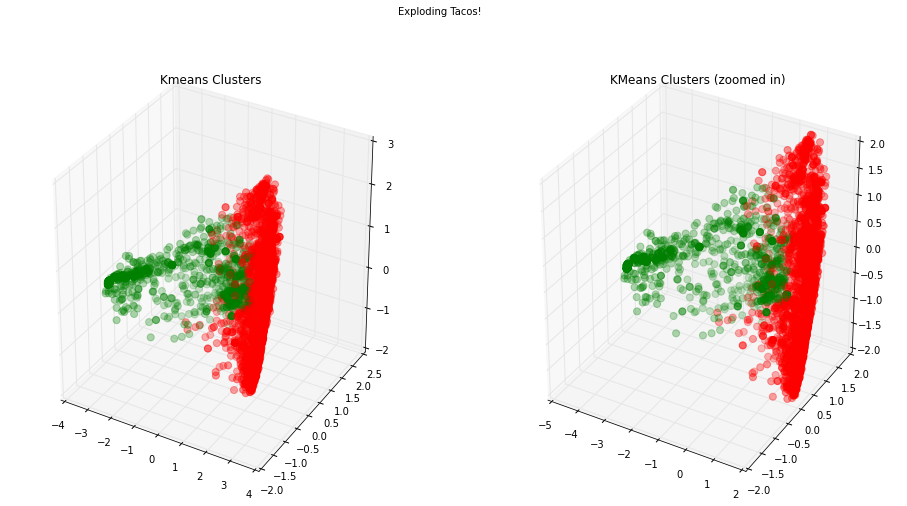

In [24]:
import pylab
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pylab.rcParams['figure.figsize'] = (16.0, 5.0)

X = PCA(n_components=3).fit_transform(domains.as_matrix(cols))
colors = ['green' if x == 1 else 'red' for x in bl_vt_labels]

figsize(12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
fig.suptitle("Exploding Tacos!")
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], alpha=.5, color=colors, s=50)
ax.set_title("Kmeans Clusters")
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_xlim(-5,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)
ax.scatter(X[:,0], X[:,1], X[:,2], alpha=.5, color=colors, s=50)
ax.set_title("KMeans Clusters (zoomed in)")
plt.show()

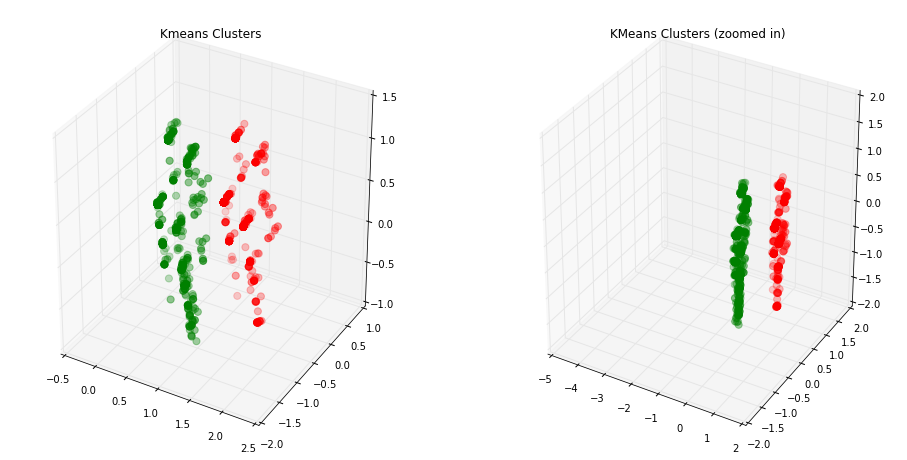

In [25]:
pylab.rcParams['figure.figsize'] = (16.0, 5.0)

X = PCA(n_components=3).fit_transform(domains.as_matrix(bl_cols))
colors = ['green' if x == 1 else 'red' for x in bl_labels]

figsize(12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], alpha=.5, color=colors, s=50)
ax.set_title("Kmeans Clusters")
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_xlim(-5,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)
ax.scatter(X[:,0], X[:,1], X[:,2], alpha=.5, color=colors, s=50)
ax.set_title("KMeans Clusters (zoomed in)")
plt.show()

In [26]:
pylab.rcParams['figure.figsize'] = (16.0, 5.0)

X = PCA(n_components=3).fit_transform(domains.as_matrix(vt_cols))
colors = ['green' if x == 1 else 'red' for x in vt_labels]

figsize(12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
fig.suptitle("Exploding Tacos!")
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], alpha=.5, color=colors, s=50)
ax.set_title("Kmeans Clusters")
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_xlim(-5,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)
ax.scatter(X[:,0], X[:,1], X[:,2], alpha=.5, color=colors, s=50)
ax.set_title("KMeans Clusters (zoomed in)")
plt.show()

### 2D

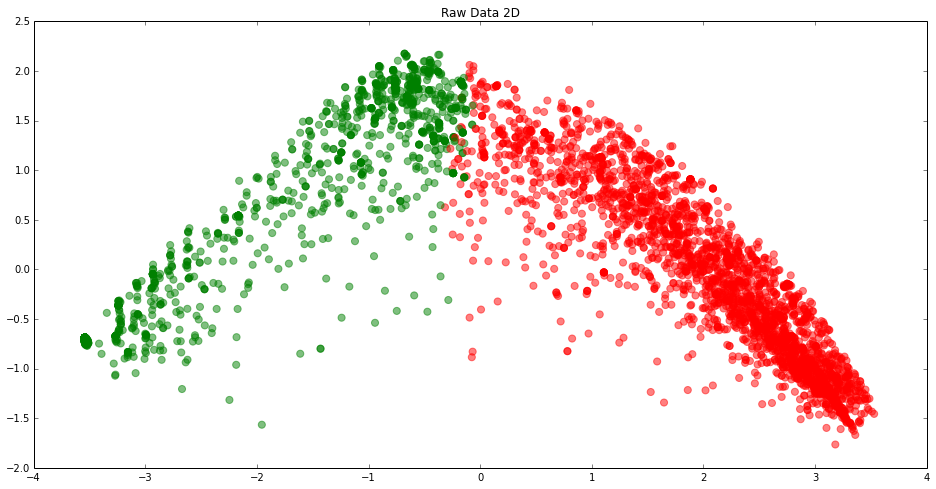

In [27]:
colors = ['green' if x == 1 else 'red' for x in bl_vt_labels]
DD = PCA(n_components=2).fit_transform(domains.as_matrix(cols))
figsize(12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(DD[:,0], DD[:,1], s=50, alpha=.5, color=colors)
ax.set_title("Raw Data 2D")
plt.show()

In [28]:
colors = ['green' if x == 1 else 'red' for x in bl_labels]
DD = PCA(n_components=2).fit_transform(domains.as_matrix(bl_cols))
figsize(12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(DD[:,0], DD[:,1], s=50, alpha=.5, color=colors)
ax.set_title("Raw Data 2D")
plt.show()

In [29]:
colors = ['green' if x == 1 else 'red' for x in vt_labels]
DD = PCA(n_components=2).fit_transform(domains.as_matrix(vt_cols))
figsize(12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(DD[:,0], DD[:,1], s=50, alpha=.5, color=colors)
ax.set_title("Raw Data 2D")
plt.show()

### 1D

5144


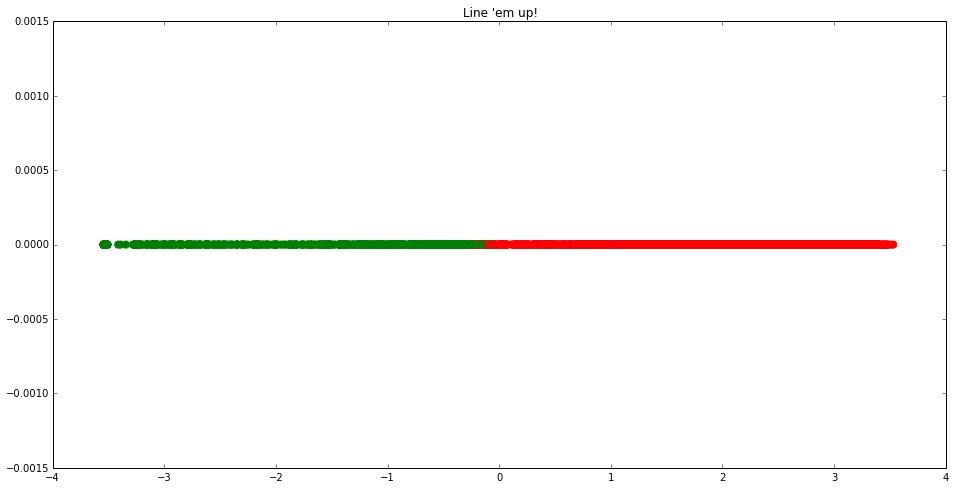

In [30]:
import numpy as np

colors = ['green' if x == 1 else 'red' for x in bl_vt_labels]
D = PCA(n_components=1).fit_transform(domains.as_matrix(cols))
print len(D)
DD = np.ndarray(shape=(len(D),2), dtype=float, order='F')
for i in range(0,len(D)):
    DD[i] = [D[i], 0.0]

figsize(12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(DD[:,0], DD[:,1], s=50, color=colors)
ax.set_title("Line 'em up!")
plt.show()

5144


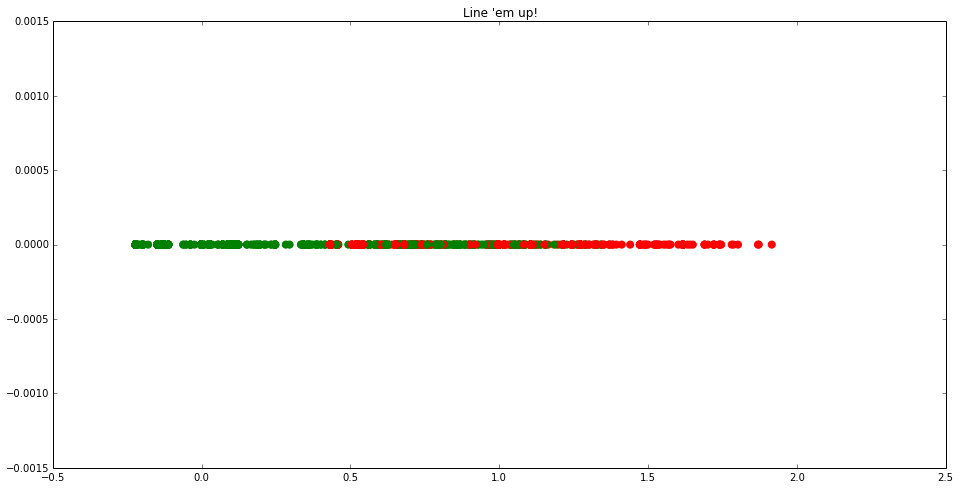

In [31]:
colors = ['green' if x == 1 else 'red' for x in bl_labels]
D = PCA(n_components=1).fit_transform(domains.as_matrix(bl_cols))
print len(D)
DD = np.ndarray(shape=(len(D),2), dtype=float, order='F')
for i in range(0,len(D)):
    DD[i] = [D[i], 0.0]

figsize(12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(DD[:,0], DD[:,1], s=50, color=colors)
ax.set_title("Line 'em up!")
plt.show()

5144


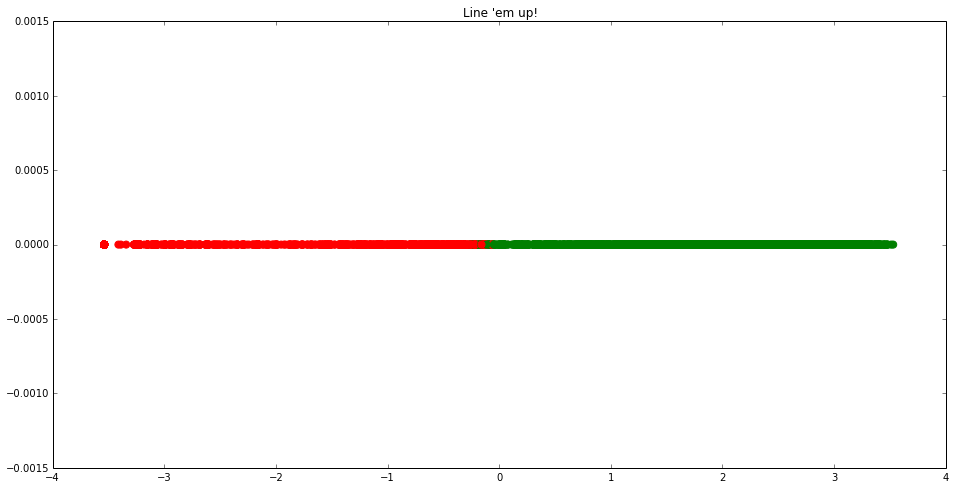

In [32]:
colors = ['green' if x == 1 else 'red' for x in vt_labels]
D = PCA(n_components=1).fit_transform(domains.as_matrix(vt_cols))
print len(D)
DD = np.ndarray(shape=(len(D),2), dtype=float, order='F')
for i in range(0,len(D)):
    DD[i] = [D[i], 0.0]

figsize(12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(DD[:,0], DD[:,1], s=50, color=colors)
ax.set_title("Line 'em up!")
plt.show()

## Scaled Data

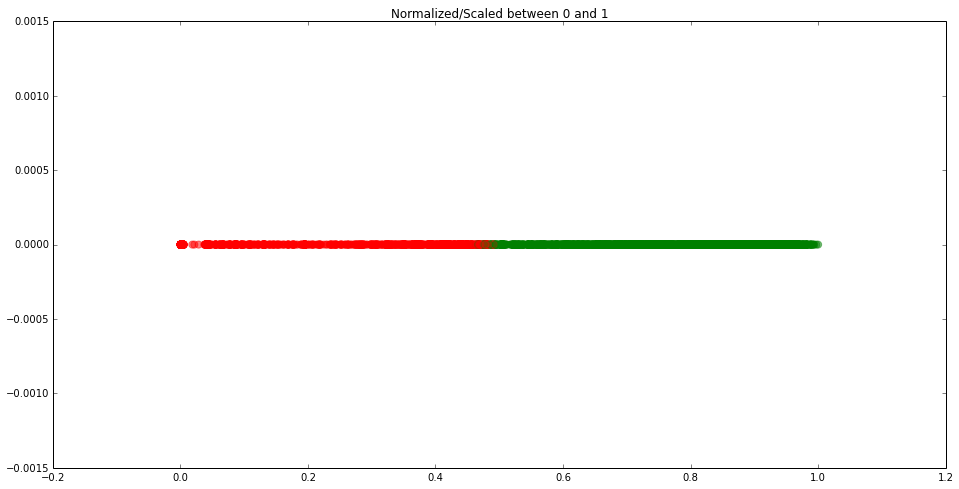

In [33]:
D = PCA(n_components=1).fit_transform(domains.as_matrix(cols))
D = [(x - D.min())/(D.max() - D.min()) for x in D]
DD = np.ndarray(shape=(len(D),2), dtype=float, order='F')
for i in range(0,len(D)):
    DD[i] = [D[i], 0.0]

figsize(12,8)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(DD[:,0], DD[:,1], s=50, alpha=.5, color=colors)
ax.set_title("Normalized/Scaled between 0 and 1")
plt.show()

## Putting It All Together

In [34]:
D = PCA(n_components=1).fit_transform(domains.as_matrix(cols))
D = [(x - D.min())/(D.max() - D.min()) for x in D]
domains['bl_vt_scaled'] = D
domains[['host','bl_vt_scaled']].head()

host       bl_vt_scaled
0                   02b123c.netsolhost.com  [0.0007444136943]
1                                   0hb.ru   [0.708017183478]
2                  0lilioo0l0o00lilil.info    [0.35505047722]
3  0n1u4og97yt85sy8faitxwt.addirectory.org   [0.640823116986]
4                      0td4nbde7.ttl60.com   [0.932481139134]

In [35]:
domains[domains['host'] == '0td4nbde7.ttl60.com'][['detections','detection_count','av_detections','av_count']]

detections  detection_count  \
4  [SpamhausDBL, BitDefender]                2   

                                       av_detections  av_count  
4  [Bkav, MicroWorld-eScan, nProtect, CMC, CAT-Qu...        46

In [36]:
domains[domains['bl_vt_scaled'] == 1]['host'].unique()

array([u'ww.turningsbyterry.com'], dtype=object)

In [37]:
domains[domains['host'] == 'turningsbyterry.com'][['detections','detection_count','av_detections','av_count']]

Empty DataFrame
Columns: [detections, detection_count, av_detections, av_count]
Index: []

In [38]:
domains[domains['bl_vt_scaled'] == 0]['host'].unique()

array([u'download.yspbrsz.net'], dtype=object)

In [39]:
domains[domains['host'] == 'download.yspbrsz.net'][['detections','detection_count','av_detections','av_count']]

detections  detection_count av_detections  \
1337  [SCUMWARE, Avira, MalwarePatrol]                3            []   

      av_count  
1337         0

In [40]:
D = PCA(n_components=1).fit_transform(domains.as_matrix(vt_cols))
D = [(x - D.min())/(D.max() - D.min()) for x in D]
domains['vt_scaled'] = D
domains[['host','vt_scaled']].head()

host         vt_scaled
0                   02b123c.netsolhost.com             [0.0]
1                                   0hb.ru  [0.705415678666]
2                  0lilioo0l0o00lilil.info  [0.351376927965]
3  0n1u4og97yt85sy8faitxwt.addirectory.org  [0.640913681668]
4                      0td4nbde7.ttl60.com  [0.932260606052]

In [41]:
domains[domains['host'] == '02b123c.netsolhost.com'][['av_detections','av_count']]

av_detections  av_count
0            []         0

In [42]:
domains[domains['host'] == '0td4nbde7.ttl60.com'][['av_detections','av_count']]

av_detections  av_count
4  [Bkav, MicroWorld-eScan, nProtect, CMC, CAT-Qu...        46

In [43]:
domains[domains['vt_scaled'] == 1]['host'].unique()

array([u'ww.turningsbyterry.com'], dtype=object)

In [44]:
domains[domains['host'] == 'ww.turningsbyterry.com'][['av_detections','av_count']]

av_detections  av_count
3521  [Bkav, MicroWorld-eScan, nProtect, K7AntiVirus...        56

In [45]:
domains[domains['vt_scaled'] == 0]['host'].unique()

array([u'02b123c.netsolhost.com'], dtype=object)

In [46]:
domains[domains['host'] == '1385065244.listentoy.com'][['av_detections','av_count']]

av_detections  av_count
55            []         0

In [47]:
D = PCA(n_components=1).fit_transform(domains.as_matrix(bl_cols))
D = [(x - D.min())/(D.max() - D.min()) for x in D]
domains['bl_scaled'] = D
domains[['host','bl_scaled']].head()

host            bl_scaled
0                   02b123c.netsolhost.com  [1.37273229865e-14]
1                                   0hb.ru     [0.699057750437]
2                  0lilioo0l0o00lilil.info     [0.731234455501]
3  0n1u4og97yt85sy8faitxwt.addirectory.org  [5.29092846235e-14]
4                      0td4nbde7.ttl60.com     [0.351012190743]

In [48]:
domains[domains['host'] == '0lilioo0l0o00lilil.info'][['detections','detection_count']]

detections  detection_count
2  [MyWOT, SCUMWARE, SURBL, hpHosts, DrWeb, Googl...                7

In [49]:
domains[domains['host'] == '0n1u4og97yt85sy8faitxwt.addirectory.org'][['detections','detection_count']]

detections  detection_count
3         []                0

In [50]:
domains[domains['bl_scaled'] == 1]['host'].unique()

array([u'storylootybuz.com'], dtype=object)

In [51]:
domains[domains['host'] == 'storylootybuz.com'][['detections','detection_count']]

detections  detection_count
3072  [MyWOT, SCUMWARE, SURBL, ThreatLog, BitDefende...                9

In [52]:
domains[domains['bl_scaled'] == 0]['host'].unique()

array([u'0v2.info'], dtype=object)

In [53]:
domains[domains['host'] == '1174378403-6.ichers.ru'][['detections','detection_count']]

detections  detection_count
32         []                0